International Trade Network Analysis: Understanding Global Economic Interactions

International trade is a fundamental aspect of the global economy, influencing economic growth, development, and geopolitical relationships. Analyzing the network of trade flows between countries and the financial transactions associated with imports and exports can provide insights into global economic dynamics and interdependencies.

In [79]:
import json
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [81]:
with open(r'C:\Users\the_s\Desktop\AI Master\Social Network Analysis\countries.json', 'r') as file:
    data = json.load(file)

In [82]:
key_mapping = {
        "Economy: Real GDP (purchasing power parity)": "GDP",
        "Economy: GDP - composition, by end use - exports of goods and services": "GDP Exports",
        "Economy: GDP - composition, by end use - imports of goods and services": "GDP Imports",
        "Economy: Exports": "Exports",
        "Economy: Exports - partners": "Export Partners",
        "Economy: Exports - commodities": "Export Commodities",
        "Economy: Imports": "Imports",
        "Economy: Imports - partners": "Import Partners",
        "Economy: Imports - commodities": "Import Commodities"
    }
old_keys = list(key_mapping.keys())

data = {country: data[country] for country in data if all(key in data[country] for key in old_keys)}

Data Preprocessing

In [85]:
for country, country_data in data.items():
        filtered_renamed_data = {key_mapping.get(key, key): value for key, value in country_data.items() if key in old_keys}
        data[country] = filtered_renamed_data

for country_data in data.values():
    for key, value in country_data.items():
        tempval = value.split(' (')[0]
        country_data[key] = tempval.strip('%')
        
for country_data in data.values():
    export_partners_str = country_data['Export Partners']
    export_partners = export_partners_str.split(', ')

    export_partner_associations = {}

    for partner_str in export_partners:
        last_space_index = partner_str.rfind(' ')
        partner = partner_str[:last_space_index]
        percentage = partner_str[last_space_index+1:]
        percentage = percentage.replace(',', '')
        percentage = percentage.replace('%', '')

        export_partner_associations[partner] = percentage
        
    country_data['Export Partners'] = export_partner_associations

    import_partners_str = country_data['Import Partners']
    import_partners = import_partners_str.split(', ')

    import_partner_associations = {}

    for partner_str in import_partners:
        last_space_index = partner_str.rfind(' ')
        partner = partner_str[:last_space_index]
        percentage = partner_str[last_space_index+1:]
        percentage = percentage.replace(',', '')
        percentage = percentage.replace('%', '')

        import_partner_associations[partner] = percentage

    country_data['Import Partners'] = import_partner_associations

In [87]:
print(data['Afghanistan'])

{'GDP': '$60.802 billion', 'GDP Exports': '6.7', 'GDP Imports': '-47.6', 'Exports': '$1.476 billion', 'Export Partners': {'United Arab Emirates': '45', 'Pakistan': '24', 'India': '22', 'China': '1'}, 'Export Commodities': 'gold, figs, grapes, cotton, fruits and nuts, coal', 'Imports': '$6.983 billion', 'Import Partners': {'United Arab Emirates': '23', 'Pakistan': '17', 'India': '13', 'Uzbekistan': '7', 'China': '9'}, 'Import Commodities': 'wheat flours, broadcasting equipment, refined petroleum, rolled tobacco, aircraft parts, synthetic fabrics'}


In [88]:
### Exports df
export_data = []
for country, exports in data.items():
    export_partners = exports.get('Export Partners', {})
    for partner, weight in export_partners.items():
        export_data.append({'source': country, 'target': partner, 'weight': float(weight)})

exports_df = pd.DataFrame(export_data)
exports_df

,source,target,weight
0,Afghanistan,United Arab Emirates,45.0
1,Afghanistan,Pakistan,24.0
2,Afghanistan,India,22.0
3,Afghanistan,China,1.0
4,Albania,Italy,45.0
...,...,...,...
971,Zambia,Democratic Republic of the Congo,9.0
972,Zambia,Singapore,8.0
973,Zimbabwe,United Arab Emirates,40.0
974,Zimbabwe,South Africa,23.0


In [89]:
### Imports df
import_data = []
for country, imports in data.items():
    import_partners = exports.get('Import Partners', {})
    for partner, weight in import_partners.items():
        import_data.append({'source': country, 'target': partner, 'weight': float(weight)})

imports_df = pd.DataFrame(import_data)
imports_df

,source,target,weight
0,Afghanistan,South Africa,41.0
1,Afghanistan,Singapore,23.0
2,Afghanistan,China,8.0
3,Albania,South Africa,41.0
4,Albania,Singapore,23.0
...,...,...,...
616,Zambia,Singapore,23.0
617,Zambia,China,8.0
618,Zimbabwe,South Africa,41.0
619,Zimbabwe,Singapore,23.0


Graph

In [92]:
# Create a directed graph
G = nx.DiGraph()

# Add edges from exports
for _, row in exports_df.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'], trade_type='export')

# Add edges from imports
for _, row in imports_df.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'], trade_type='import')

num_nodes = G.number_of_nodes()
print(f"Number of nodes: {num_nodes}")

Number of nodes: 218


Measures

Degree Centrailty

Nodes with high degree centrality have a large number of connections and are considered influential or important within the network. Nodes with high degree centrality can be critical for maintaining the integrity of the network. Their removal might significantly disrupt the network's connectivity.

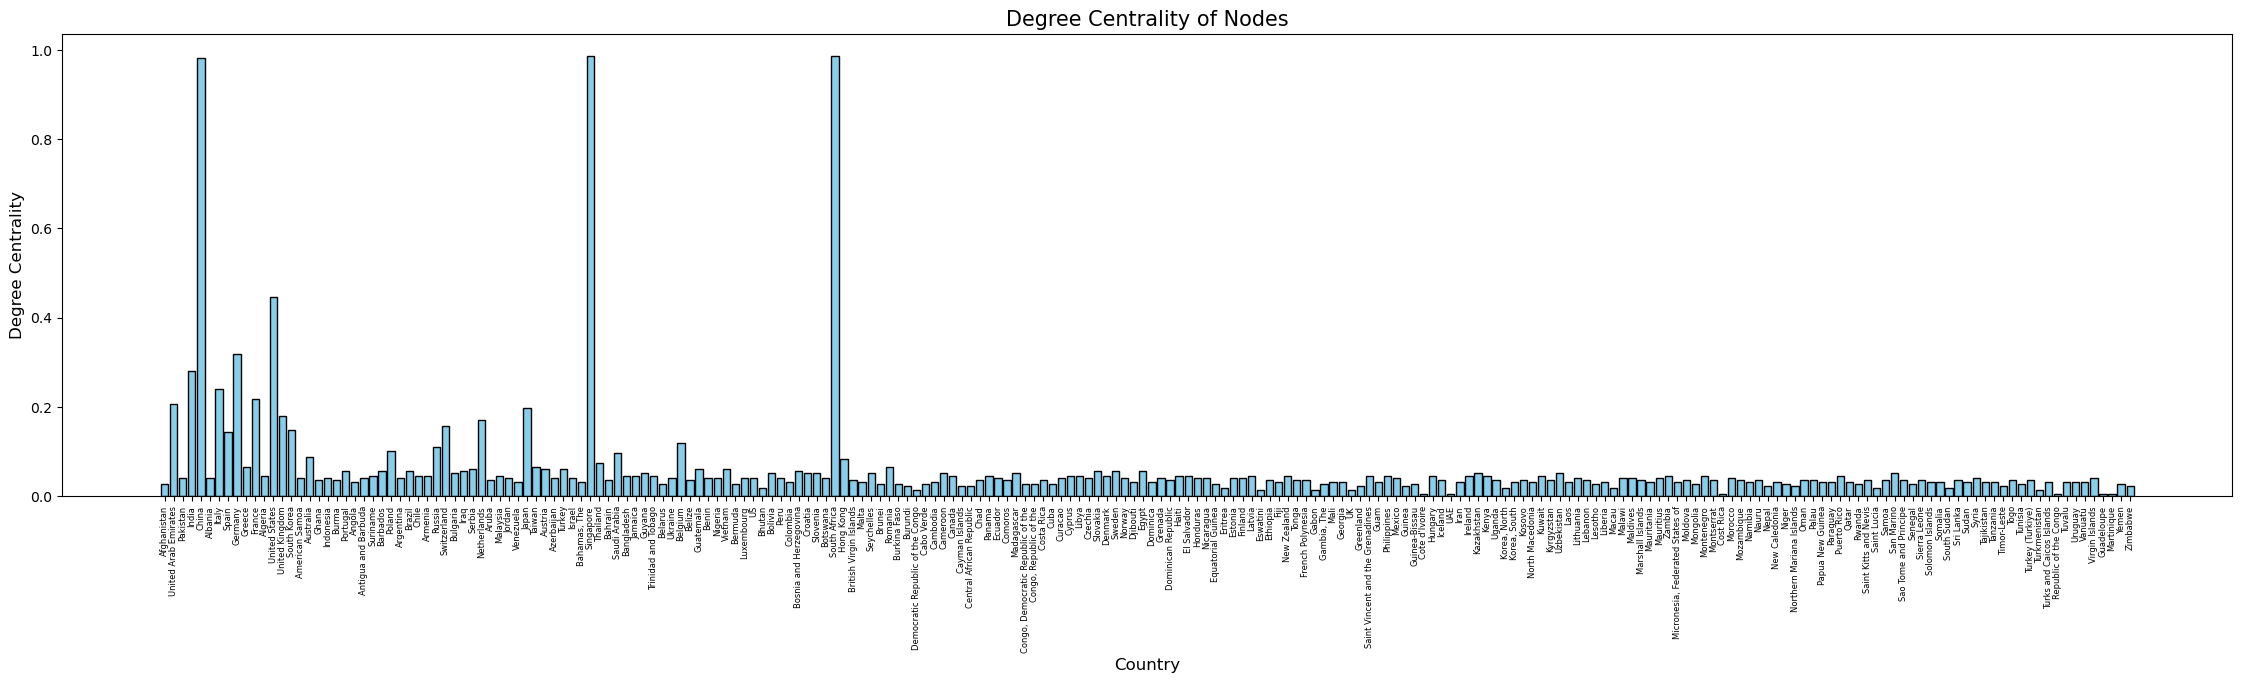

Nodes (Countries) with High Degree Centrality (> 0.3):
China: 0.9816
Germany: 0.3180
United States: 0.4470
Singapore: 0.9862
South Africa: 0.9862


In [140]:
degree_centrality = nx.degree_centrality(G)

countries = list(degree_centrality.keys())
degree_centrality_values = list(degree_centrality.values())

# Plot histogram
def centrality(countries, cent, centrality_values, type, threshold):
    plt.figure(figsize=(28, 6))
    plt.bar(countries, centrality_values, color='skyblue', edgecolor='black')
    plt.xticks(rotation=90, fontsize=6)
    plt.title(type+' of Nodes', fontsize=15)
    plt.xlabel('Country', fontsize=12)
    plt.ylabel(type, fontsize=12)
    plt.show()

    high_centrality_nodes = {node: centrality for node, centrality in cent.items() if centrality > threshold}
    print('Nodes (Countries) with High '+type+' (> '+str(threshold)+'):')
    for node, centrality in high_centrality_nodes.items():
        print(f"{node}: {centrality:.4f}")
    return high_centrality_nodes

high_degree_nodes = centrality(countries, degree_centrality, degree_centrality_values, type='Degree Centrality',threshold=0.3)

Degree Centrailty Distribution

We calculate the degree centrality distribution and fit a power-law model to the log-transformed degree centrality values. This approach can reveal if the network follows a power-law distribution, which is common in many real-world networks.

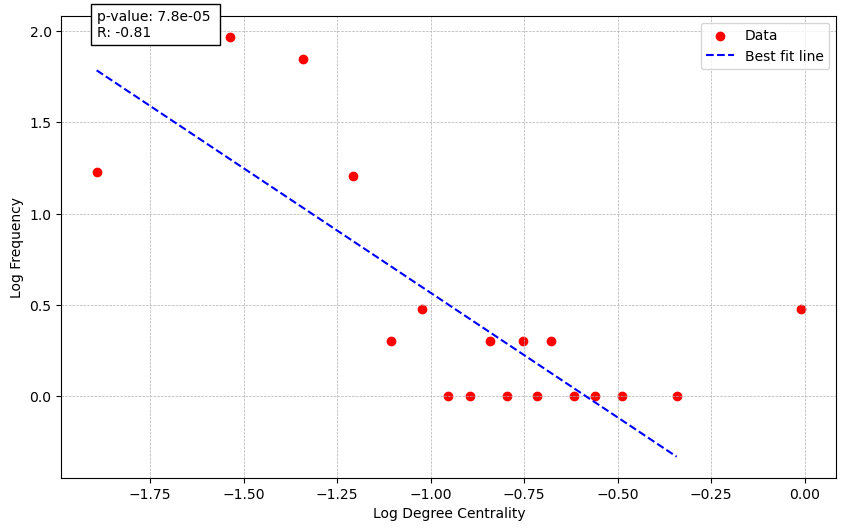

The slope of the line is: -1.3642093643893693


In [143]:
def plot_centrality_power_law(centrality_values, G, bins, type):
    
    # Calculate histogram
    freq, bins = np.histogram(centrality_values, bins=bins)
    
    # Calculate bin centers
    x = (bins[:-1] + bins[1:]) / 2  # x = center value of each bin
    y = freq  # y = occurrence
    
    # Filter out zero values
    non_zero_indices = np.where(y > 0)
    x_display = x[non_zero_indices]
    y_display = y[non_zero_indices]
    
    # Exclude the last value for the fit (if it's an outlier)
    fit_points = np.where(x_display < np.max(x_display))
    x_fit = x_display[fit_points]
    y_fit = y_display[fit_points]
    
    # Take the logarithm of x and y
    log_x_display = np.log10(x_display)
    log_y_display = np.log10(y_display)
    log_x_fit = np.log10(x_fit)
    log_y_fit = np.log10(y_fit)
    
    # Fit a straight line to the data
    coeffs = np.polyfit(log_x_fit, log_y_fit, 1)
    
    # Generate y-values for the fitted line
    fitted_y = coeffs[0] * log_x_fit + coeffs[1]
    
    # Perform linear regression and get p-value
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_fit, log_y_fit)
    
    # Plot the data and the fit
    plt.figure(figsize=(10, 6))
    plt.scatter(log_x_display, log_y_display, color='r', label='Data')
    plt.plot(log_x_fit, fitted_y, 'b--', label='Best fit line')  # Plot fitted line
    plt.legend()
    plt.xlabel('Log '+type+' Centrality')
    plt.ylabel('Log Frequency')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.text(min(log_x_display), max(log_y_display), f'p-value: {p_value:.1e} \nR: {r_value:.2f}', bbox=dict(facecolor='white')) # Add p-value to the plot
    
    plt.show()
    
    print(f"The slope of the line is: {slope}")
    return slope

slope = plot_centrality_power_law(degree_centrality_values, G, bins=60, type='Degree')

Cumulative Distribution for Degree Centrality

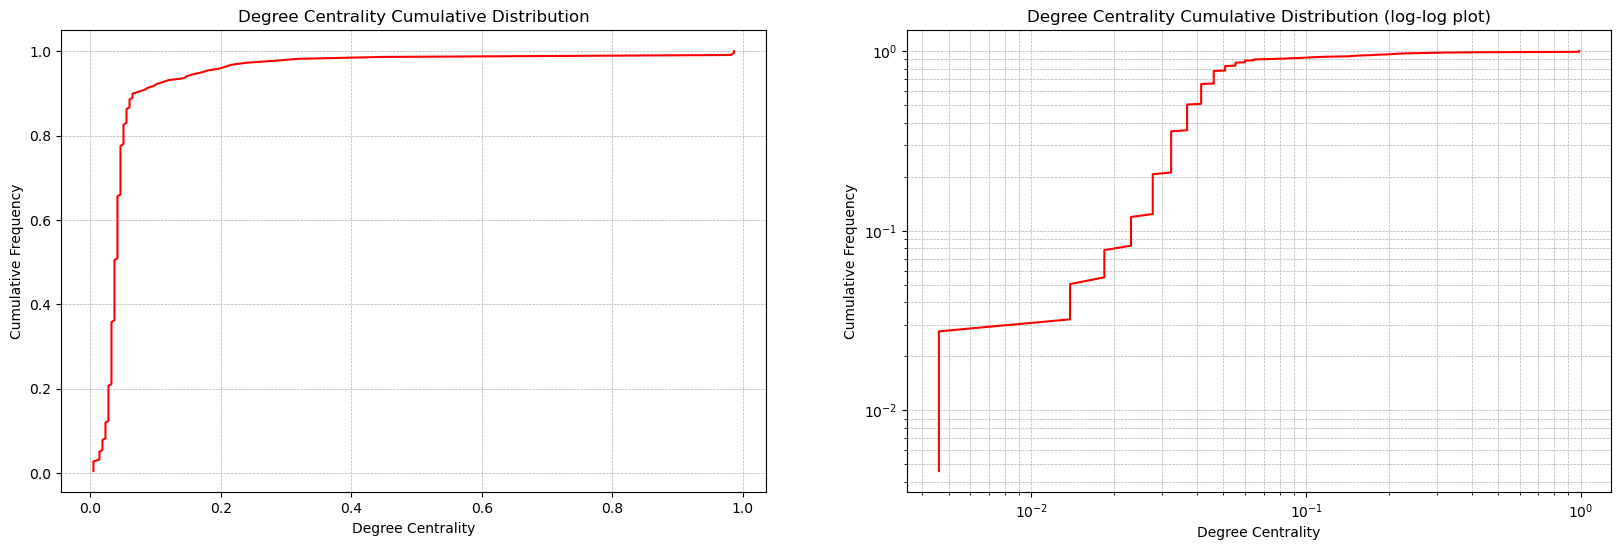

In [145]:
def cumulative_distribution(centrality_values,type):
    # Sort the degree centrality values
    sorted_centrality_values = np.sort(centrality_values)
    
    # Cumulative distribution
    cdf = np.arange(1, len(sorted_centrality_values) + 1) / len(sorted_centrality_values)
    
    # CDF Plot
    plt.figure(figsize=(20, 6))
    
    # Linear scale plot
    plt.subplot(1, 2, 1)
    plt.plot(sorted_centrality_values, cdf, color='r')
    plt.xlabel(type+' Centrality')
    plt.ylabel('Cumulative Frequency')
    plt.title(type+' Centrality Cumulative Distribution')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    
    # Log-log scale plot
    plt.subplot(1, 2, 2)
    plt.plot(sorted_centrality_values, cdf, color='r')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(type+' Centrality')
    plt.ylabel('Cumulative Frequency')
    plt.title(type+' Centrality Cumulative Distribution (log-log plot)')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    
    plt.show()

cumulative_distribution(degree_centrality_values,type='Degree')

Eigenvector centrality

Eigenvector centrality is a measure of the influence of a node in a network. Unlike degree centrality, which only considers the number of direct connections a node has, eigenvector centrality also considers the importance of the nodes to which it is connected. A node with high eigenvector centrality is connected to many nodes that themselves have high centrality.

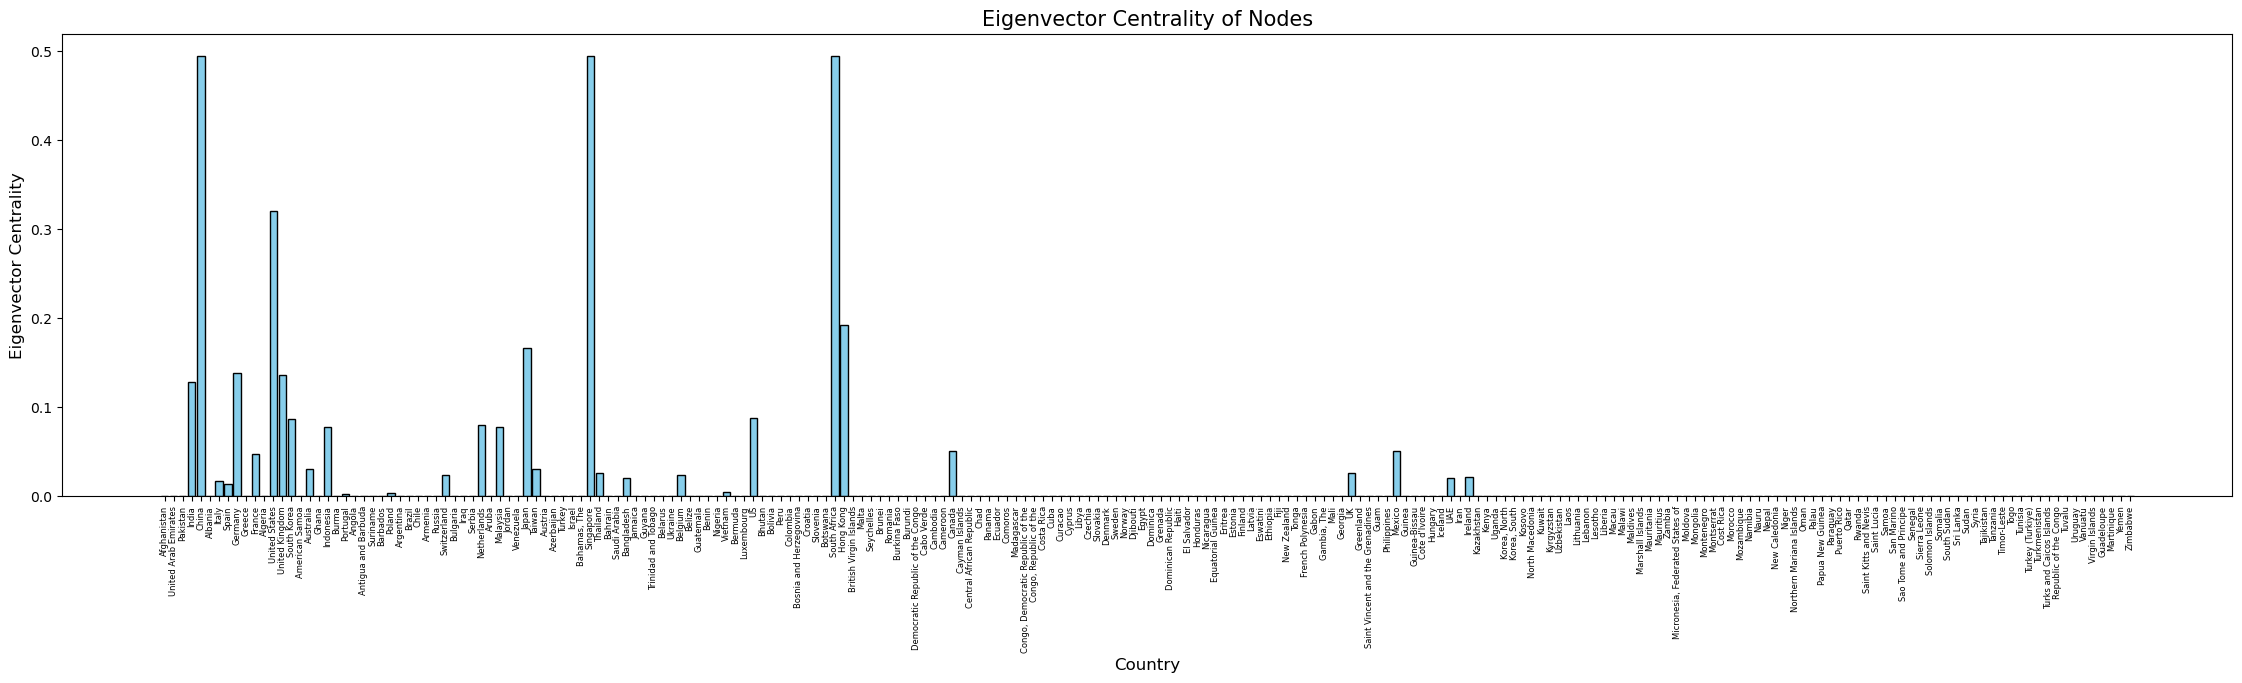

Nodes (Countries) with High Eigenvector Centrality (> 0.3):
China: 0.4941
United States: 0.3206
Singapore: 0.4941
South Africa: 0.4941


In [148]:
eigenvector_centrality = nx.eigenvector_centrality(G)
eigenvector_centrality_values = list(eigenvector_centrality.values())

high_eigenvector_nodes = centrality(countries, eigenvector_centrality, eigenvector_centrality_values, type='Eigenvector Centrality',threshold=0.3)

Eigenvector centrality distribution

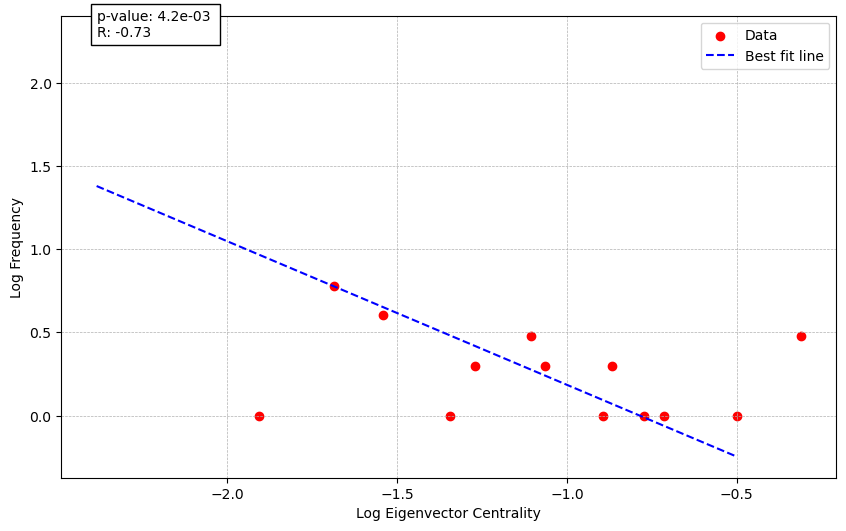

The slope of the line is: -0.863047835760255


In [150]:
slope = plot_centrality_power_law(eigenvector_centrality_values, G, bins=60, type='Eigenvector')

Cumulative Distribution for Eigenvector Centrality

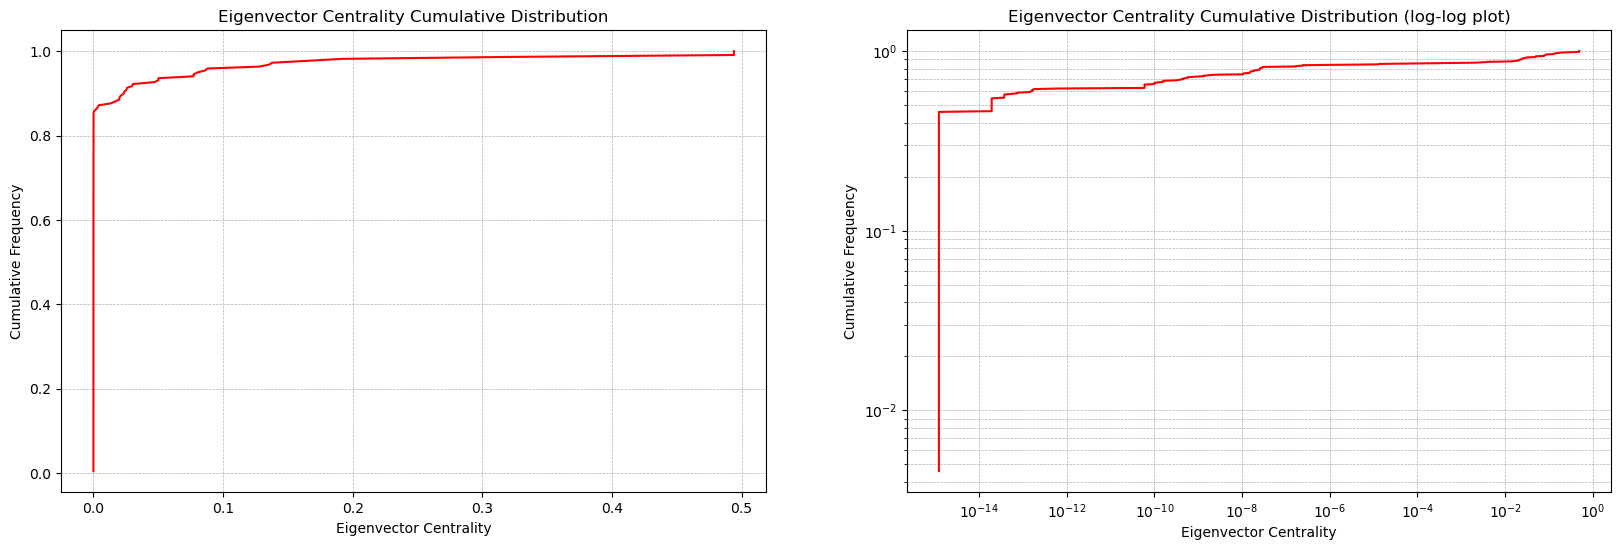

In [152]:
cumulative_distribution(eigenvector_centrality_values,type='Eigenvector')

Betweenness centrality

Betweenness centrality is a measure of a node's importance based on its position within the network. Specifically, it quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. Nodes with high betweenness centrality have significant influence within the network because they control the flow of information between other nodes.

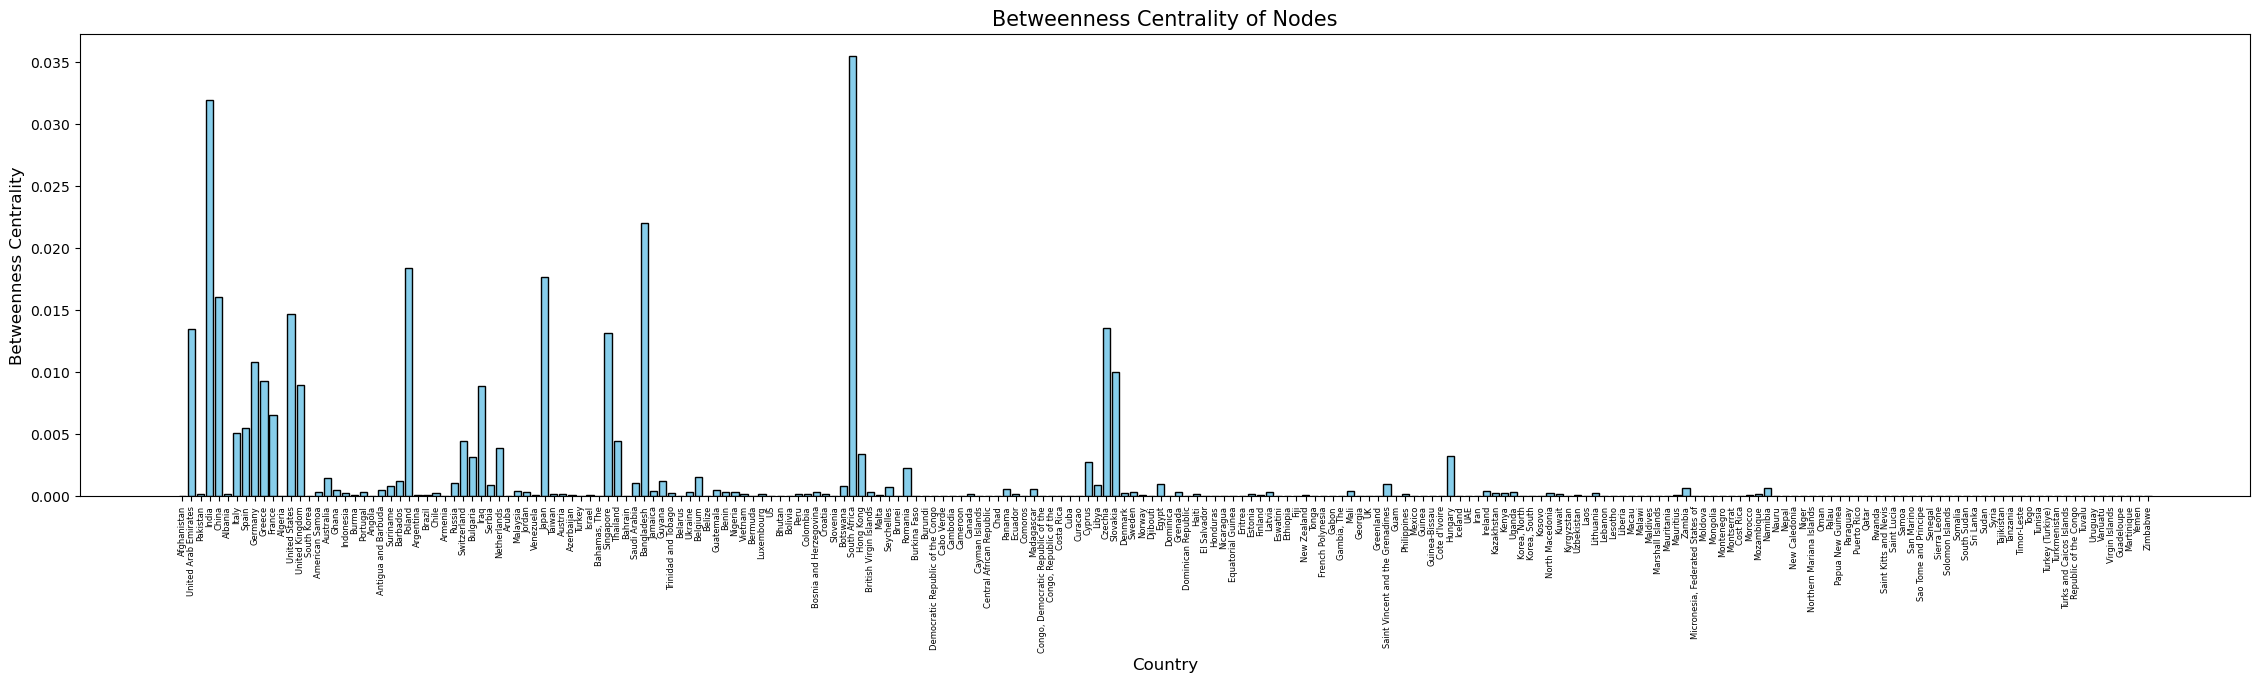

Nodes (Countries) with High Betweenness Centrality (> 0.015):
India: 0.0320
China: 0.0160
Poland: 0.0184
Japan: 0.0177
Bangladesh: 0.0220
South Africa: 0.0355


In [155]:
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_centrality_values = list(betweenness_centrality.values())

high_betweenness_nodes = centrality(countries, betweenness_centrality, betweenness_centrality_values, type='Betweenness Centrality',threshold=0.015)

Betweenness Centrality distribution

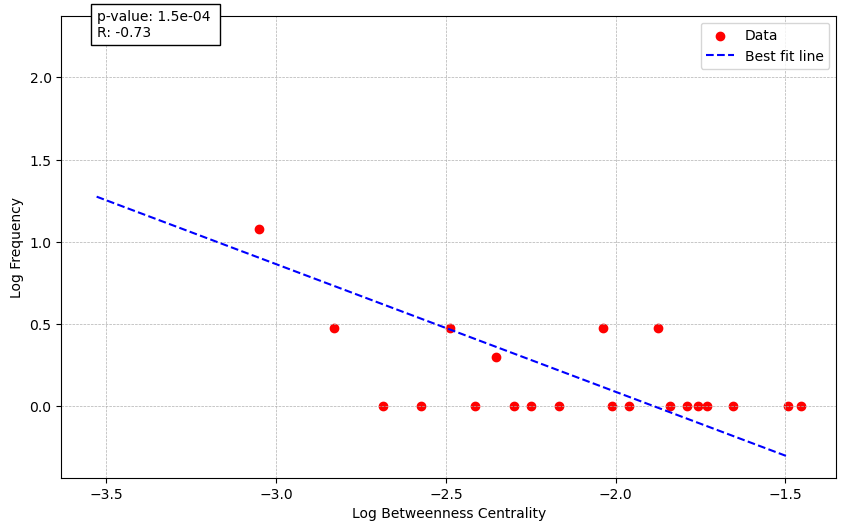

The slope of the line is: -0.7769237243967496


In [157]:
slope = plot_centrality_power_law(betweenness_centrality_values, G, bins=60, type='Betweenness')

Cumulative Distribution for Betweenness Centrality

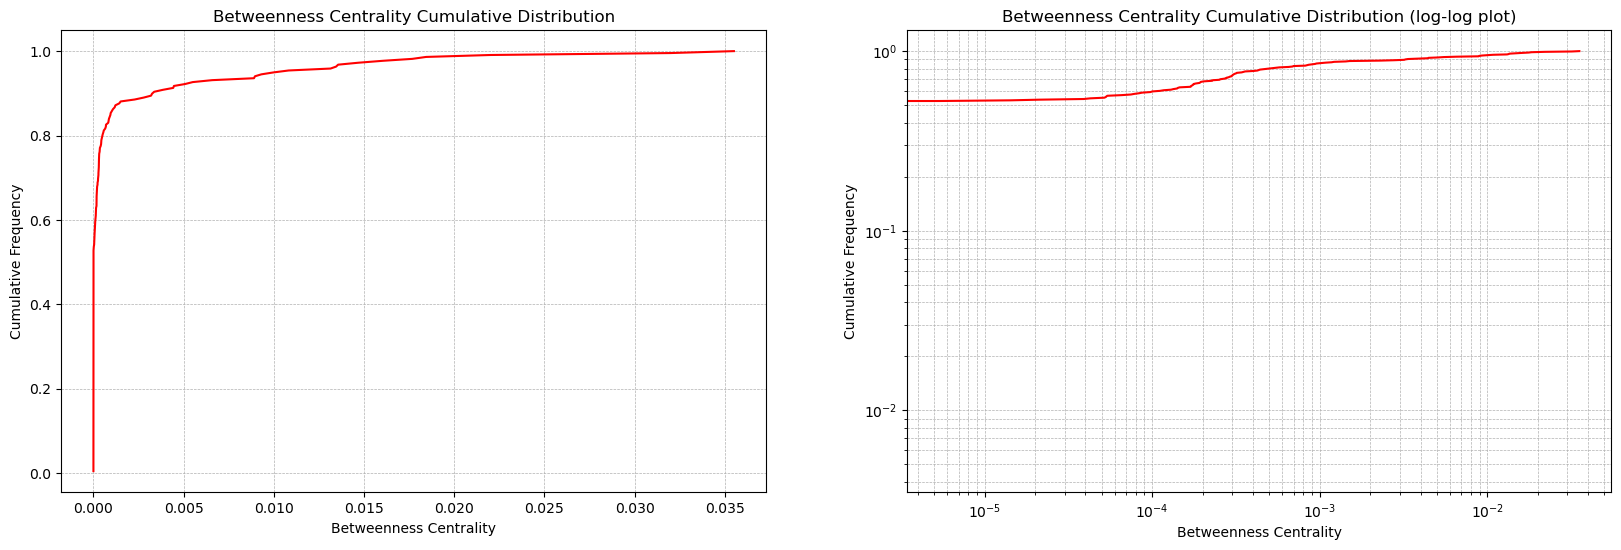

In [159]:
cumulative_distribution(betweenness_centrality_values,type='Betweenness')

Closeness centrality

Closeness centrality is a measure of how quickly a node can reach all other nodes in a network. It is calculated as the reciprocal of the average shortest path distance from a node to all other nodes. Nodes with high closeness centrality can quickly communicate with all other nodes, making them effective for disseminating information or resources.

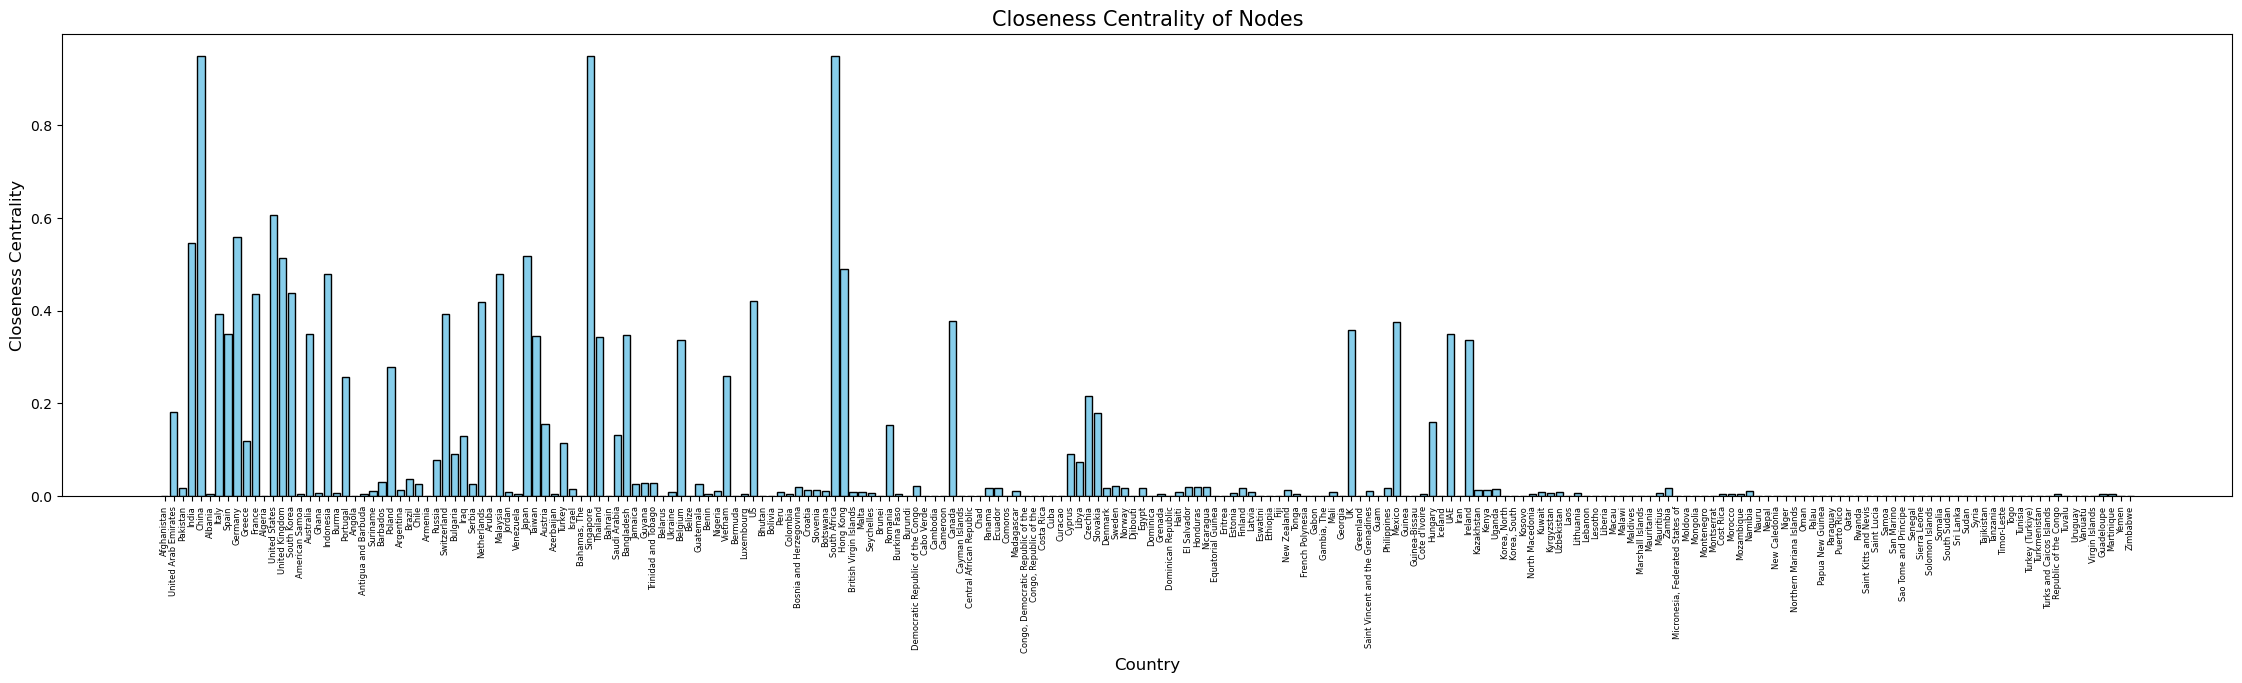

Nodes (Countries) with High Closeness Centrality (> 0.5):
India: 0.5463
China: 0.9493
Germany: 0.5587
United States: 0.6073
United Kingdom: 0.5133
Japan: 0.5187
Singapore: 0.9493
South Africa: 0.9493


In [162]:
closeness_centrality = nx.closeness_centrality(G)
closeness_centrality_values = list(closeness_centrality.values())

high_closeness_nodes = centrality(countries, closeness_centrality, closeness_centrality_values, type='Closeness Centrality',threshold=0.5)

Closeness centrality distribution

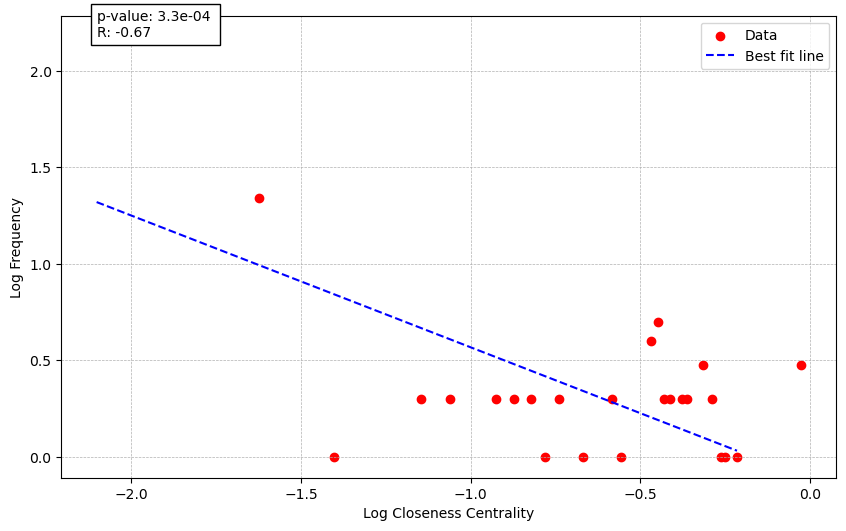

The slope of the line is: -0.6829095550489742


In [164]:
slope = plot_centrality_power_law(closeness_centrality_values, G, bins=60, type='Closeness')

Local Clustering coefficient

The local clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. It is calculated for each node in a graph and quantifies how close its neighbors are to being a complete subgraph (a clique). 

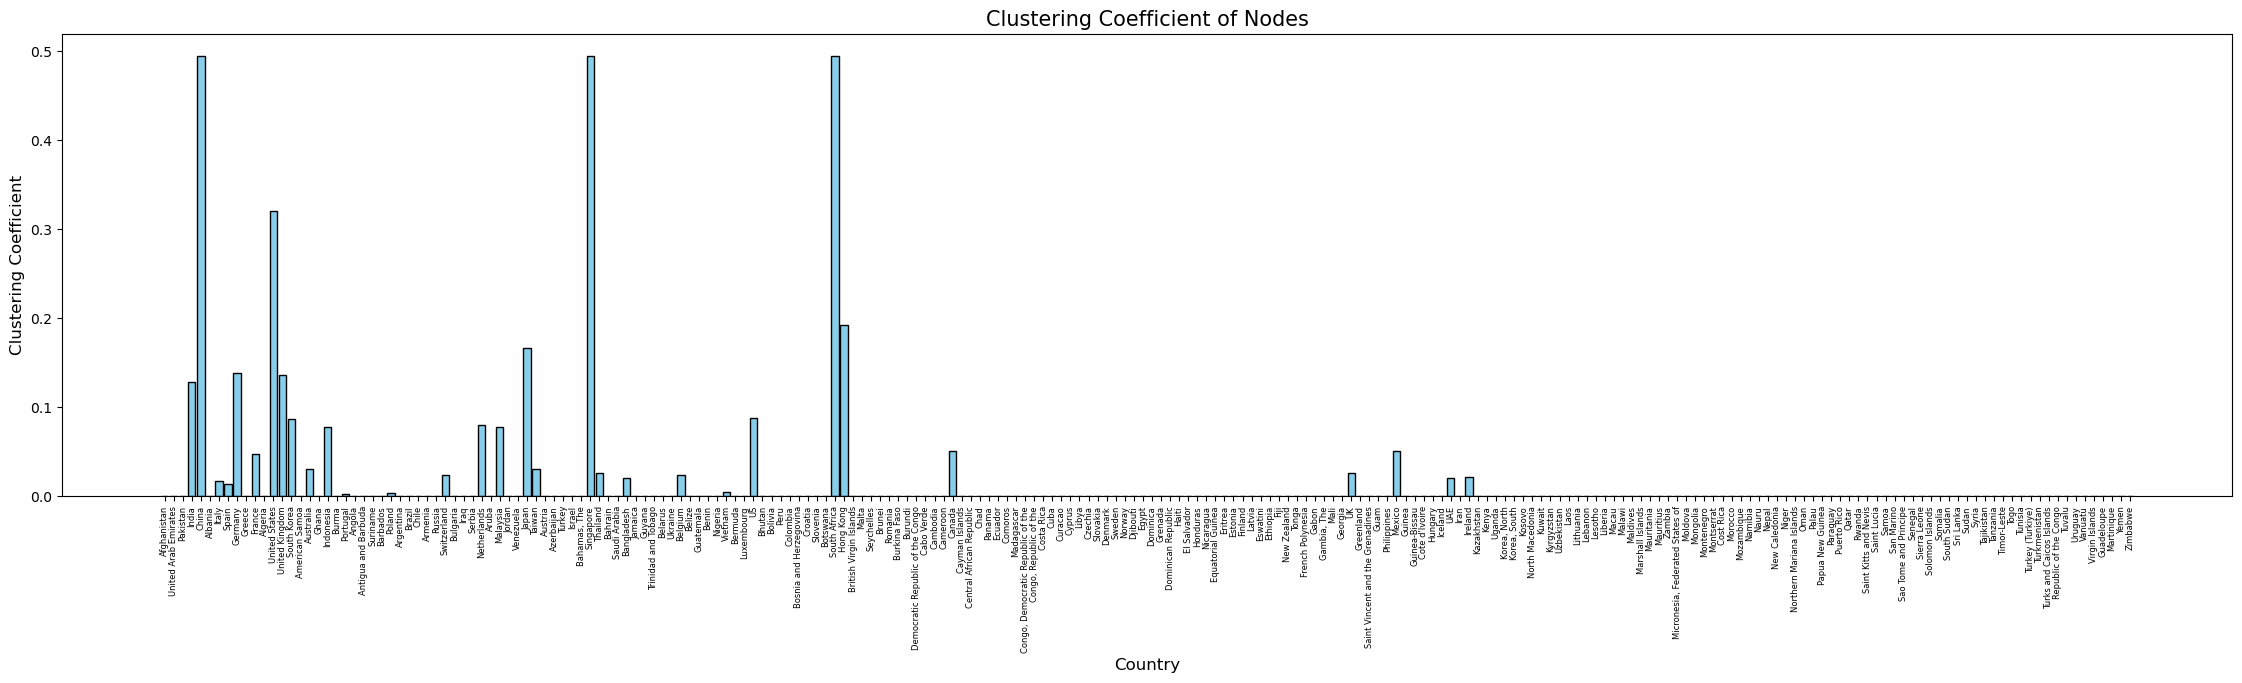

Nodes (Countries) with High Clustering Coefficient (> 0.15):
China: 0.4941
United States: 0.3206
Japan: 0.1657
Singapore: 0.4941
South Africa: 0.4941
Hong Kong: 0.1920


In [167]:
clustering_coeffs = nx.eigenvector_centrality(G)
clustering_coeffs_values = list(clustering_coeffs.values())

high_eigenvector_nodes = centrality(countries, clustering_coeffs, clustering_coeffs_values, type='Clustering Coefficient',threshold=0.15)

Correlation between Local Clustering Coefficient and Degree Centrality

Is a measure of how these two properties are related across the nodes of a graph. Degree centrality measures the number of connections a node has, while the local clustering coefficient measures the tendency of a node's neighbors to be connected with each other. By examining their correlation, we can gain insights into the structural properties of the graph.

Pearson correlation coefficient: 0.9415
P-value: 5.3437e-104


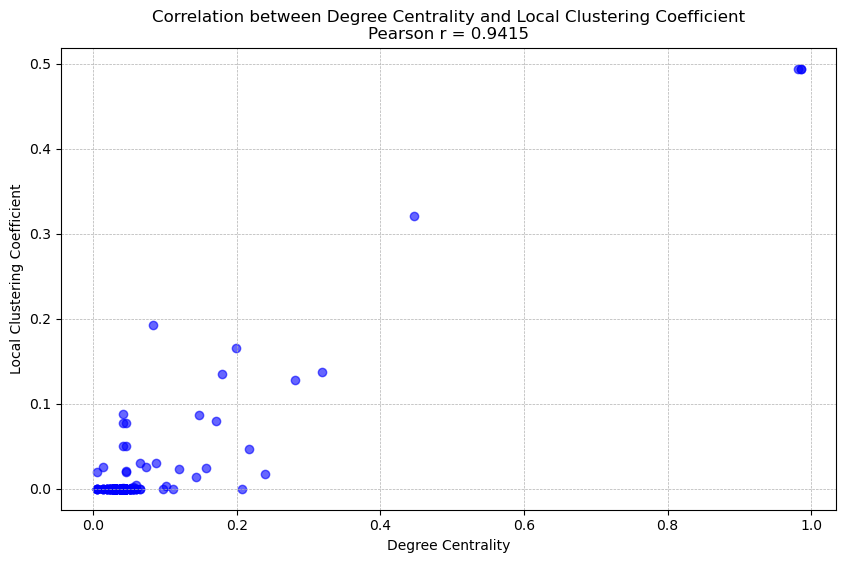

In [199]:
# Pearson correlation coefficient
correlation, p_value = stats.pearsonr(clustering_coeffs_values, degree_centrality_values)

print(f"Pearson correlation coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4e}")

# Plotting the correlation
plt.figure(figsize=(10, 6))
plt.scatter(degree_centrality_values, clustering_coeffs_values, color='b', alpha=0.6)
plt.xlabel('Degree Centrality')
plt.ylabel('Local Clustering Coefficient')
plt.title(f'Correlation between Degree Centrality and Local Clustering Coefficient\nPearson r = {correlation:.4f}')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

Cliques

Finding cliques in a graph can be useful for understanding the structure and relationships within the graph, such as identifying tightly knit groups of nodes, which might represent communities or highly interconnected subgraphs.

In [211]:
G_undirected = G.to_undirected()
cliques = list(nx.find_cliques(G_undirected))
th=7
large_cliques = [clique for clique in cliques if len(clique) > th]

print(f"Clique(s) larger than {th} nodes in the graph:")
for clique in large_cliques:
    print(clique)

largest_clique = max(cliques, key=len)
print("\nLargest clique in the graph:", largest_clique)
print("Size of the largest clique:", len(largest_clique))

Clique(s) larger than 7 nodes in the graph:
['China', 'Singapore', 'South Africa', 'Romania', 'Germany', 'Poland', 'France', 'San Marino']
['China', 'Singapore', 'South Africa', 'Bosnia and Herzegovina', 'Germany', 'Italy', 'Croatia', 'Slovenia', 'Austria']
['China', 'Singapore', 'South Africa', 'Bosnia and Herzegovina', 'Germany', 'Italy', 'Croatia', 'Serbia']
['China', 'Singapore', 'South Africa', 'Bosnia and Herzegovina', 'Germany', 'Italy', 'Montenegro', 'Serbia']
['China', 'Singapore', 'South Africa', 'Germany', 'Italy', 'France', 'Slovenia', 'Switzerland']
['China', 'Singapore', 'South Africa', 'Germany', 'Italy', 'France', 'Luxembourg', 'Belgium']
['China', 'Singapore', 'South Africa', 'Germany', 'Italy', 'France', 'Spain', 'Albania']
['China', 'Singapore', 'South Africa', 'Germany', 'Italy', 'France', 'Spain', 'Libya']
['China', 'Singapore', 'South Africa', 'Germany', 'Italy', 'Austria', 'Slovenia', 'Switzerland']
['China', 'Singapore', 'South Africa', 'Germany', 'Ireland', 'Un

K-core and core periphery structures

K-core of a graph is a maximal subgraph in which each vertex has at least degree k. In other words, it's a subgraph where every node is connected to at least k other nodes in that subgraph.

In [218]:
k = 4  # Define the k value
G_noloops = G.copy() 
G_noloops.remove_edges_from(nx.selfloop_edges(G_noloops)) # Remove self-loops
k_core_subgraph = nx.k_core(G_noloops, k)

k_core_nodes = k_core_subgraph.nodes()
print(f"Nodes in the {k}-core:", k_core_nodes)

Nodes in the 4-core: ['Afghanistan', 'United Arab Emirates', 'Pakistan', 'India', 'China', 'Albania', 'Italy', 'Spain', 'Germany', 'Greece', 'France', 'Algeria', 'United States', 'United Kingdom', 'South Korea', 'American Samoa', 'Australia', 'Ghana', 'Indonesia', 'Burma', 'Portugal', 'Angola', 'Antigua and Barbuda', 'Suriname', 'Barbados', 'Poland', 'Argentina', 'Brazil', 'Chile', 'Armenia', 'Russia', 'Switzerland', 'Bulgaria', 'Iraq', 'Serbia', 'Netherlands', 'Aruba', 'Malaysia', 'Jordan', 'Venezuela', 'Japan', 'Taiwan', 'Austria', 'Azerbaijan', 'Turkey', 'Israel', 'Bahamas, The', 'Singapore', 'Thailand', 'Bahrain', 'Saudi Arabia', 'Bangladesh', 'Jamaica', 'Guyana', 'Trinidad and Tobago', 'Belarus', 'Ukraine', 'Belgium', 'Belize', 'Guatemala', 'Benin', 'Nigeria', 'Vietnam', 'Bermuda', 'Luxembourg', 'US', 'Bhutan', 'Bolivia', 'Peru', 'Colombia', 'Bosnia and Herzegovina', 'Croatia', 'Slovenia', 'Botswana', 'South Africa', 'Hong Kong', 'British Virgin Islands', 'Malta', 'Seychelles', 'B

Assortative mixing by degree

Density

Pagerank

In [173]:
pagerank = nx.pagerank(G)